### Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Data Ingestion and Exploration

In [8]:
df=pd.read_csv("complaints_processed.csv")
df.head()

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


In [9]:
#Dropping irrelevant columns
df.drop(["Unnamed: 0"],axis=1,inplace=True)

In [10]:
print(f"Shape of the dataset: {df.shape}")

Shape of the dataset: (172088, 2)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172088 entries, 0 to 172087
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   product    172088 non-null  object
 1   narrative  172078 non-null  object
dtypes: object(2)
memory usage: 2.6+ MB


**Discovery**: 10 Missing complaint messages. Should drop them.

In [12]:
#Finding missing data
df[df['narrative'].isna()]

,product,narrative
2343,credit_reporting,NaN
9758,credit_reporting,NaN
9759,credit_reporting,NaN
39363,credit_reporting,NaN
149109,debt_collection,NaN
160725,debt_collection,NaN
164167,credit_reporting,NaN
166575,retail_banking,NaN
168211,credit_reporting,NaN
169176,credit_reporting,NaN


In [13]:
new_df=df[~df['narrative'].isna()]

In [14]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172078 entries, 0 to 172087
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   product    172078 non-null  object
 1   narrative  172078 non-null  object
dtypes: object(2)
memory usage: 3.9+ MB


In [15]:
product_categories=new_df['product'].unique()
print(f"Product categories: {product_categories}")

Product categories: ['credit_card' 'retail_banking' 'credit_reporting' 'mortgages_and_loans'
 'debt_collection']


In [16]:
grouped_data=new_df.groupby('product').count()

**Insight**: Classes are imbalanced.

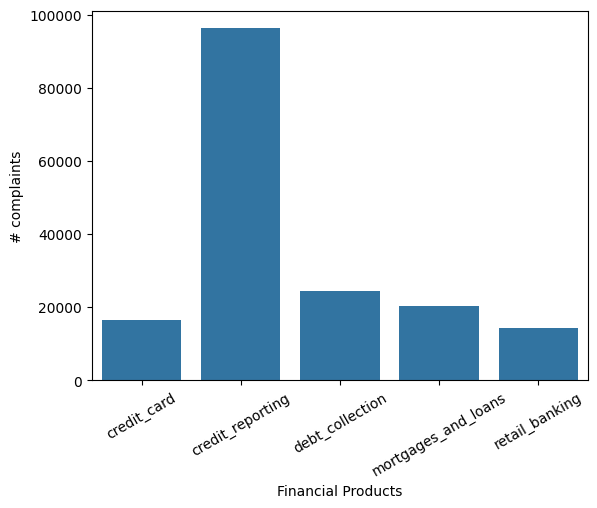

In [17]:
sns.barplot(x='product',y='narrative',data=grouped_data)
plt.xticks(rotation=30)
plt.xlabel("Financial Products")
plt.ylabel("# complaints")
plt.show()

### 2. Data preprocessing

In [20]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
import re
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def clean_complaint(text):
    """
        text: string
        return: cleaned string
    """
    text = str(text)
    text = text.lower()
    text = re.compile('[^a-z\s]').sub('', text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [22]:
new_df['narrative'].apply(clean_complaint)

0         purchase order day shipping amount receive pro...
1         forwarded message date tue subject please inve...
2         forwarded message cc sent friday pdt subject f...
3         payment history missing credit report speciali...
4         payment history missing credit report made mis...
                                ...                        
172083    zales comenity bank closed sold account report...
172084    zelle suspended account without cause banking ...
172085    zero contact made debt supposedly resolved fou...
172086    zillow home loan nmls nmls actual quote provid...
172087    zuntafi sent notice willing settle defaulted s...
Name: narrative, Length: 172078, dtype: object

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
#max number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS,
                      filters='!"#$%&(\')*+,-./:;<=>?@[\]^_`{|}~',
                      lower=True)
tokenizer.fit_on_texts(new_df['narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 46002 unique tokens.


In [25]:
X = tokenizer.texts_to_sequences(new_df['narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (172078, 250)


In [26]:
y = pd.get_dummies(new_df['product']).values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (172078, 5)


### 3. Model Training

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.20, random_state = 42)
print(f"X-train shape : {X_train.shape} ; Y-train shape : {Y_train.shape}")
print(f"X-test shape : {X_test.shape} ; Y-test shape : {Y_test.shape}")

X-train shape : (137662, 250) ; Y-train shape : (137662, 5)
X-test shape : (34416, 250) ; Y-test shape : (34416, 5)


In [28]:
#Model Architecture
model = tf.keras.Sequential([
    # Embedding layer
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),
    # Spatial Dropout layer for regularization
    tf.keras.layers.SpatialDropout1D(0.2),
    # Bidirectional LSTM layer (returning sequences)
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    # Bidirectional LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    # Dense output layer with softmax activation for classification
    tf.keras.layers.Dense(5, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (Spatial  (None, 250, 100)          0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 250, 512)          731136    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               656384    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 5)                 1285      
                                                        

In [29]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer='Nadam',
    metrics=["CategoricalAccuracy"]
)


In [30]:
num_epochs = 5
batch_size = 128

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

history = model.fit(
    X_train, Y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[callback]
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


968/968 [==============================] - 223s 219ms/step - loss: 0.5771 - categorical_accuracy: 0.7972 - val_loss: 0.4176 - val_categorical_accuracy: 0.8614
Epoch 2/5
968/968 [==============================] - 142s 147ms/step - loss: 0.3813 - categorical_accuracy: 0.8720 - val_loss: 0.3756 - val_categorical_accuracy: 0.8724
Epoch 3/5
968/968 [==============================] - 132s 137ms/step - loss: 0.3154 - categorical_accuracy: 0.8935 - val_loss: 0.3633 - val_categorical_accuracy: 0.8801
Epoch 4/5
968/968 [==============================] - 130s 135ms/step - loss: 0.2769 - categorical_accuracy: 0.9065 - val_loss: 0.3506 - val_categorical_accuracy: 0.8822
Epoch 5/5
968/968 [==============================] - 132s 136ms/step - loss: 0.2471 - categorical_accuracy: 0.9167 - val_loss: 0.3721 - val_categorical_accuracy: 0.8823


In [45]:
model.save("/content/drive/MyDrive/PCB/model.tf")

In [32]:
history.history

{'loss': [0.5771007537841797,
  0.381287544965744,
  0.31538060307502747,
  0.27690404653549194,
  0.24708598852157593],
 'categorical_accuracy': [0.7972315549850464,
  0.8719722628593445,
  0.8934823870658875,
  0.9065014719963074,
  0.9166713953018188],
 'val_loss': [0.41764721274375916,
  0.37562549114227295,
  0.3632546365261078,
  0.3506145179271698,
  0.37208443880081177],
 'val_categorical_accuracy': [0.8614076972007751,
  0.8724486231803894,
  0.8800755143165588,
  0.8821820020675659,
  0.8823273181915283]}

### 4. Model Evaluation

In [33]:
accuracy = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]))

1076/1076 [==============================] - 23s 22ms/step - loss: 0.3710 - categorical_accuracy: 0.8799
Test set
  Loss: 0.371
  Accuracy: 0.880


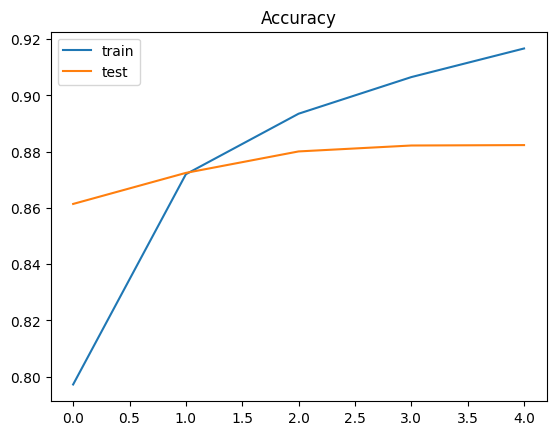

In [35]:
plt.title('Accuracy')
plt.plot(history.history['categorical_accuracy'], label='train')
plt.plot(history.history['val_categorical_accuracy'], label='test')
plt.legend()
plt.show()

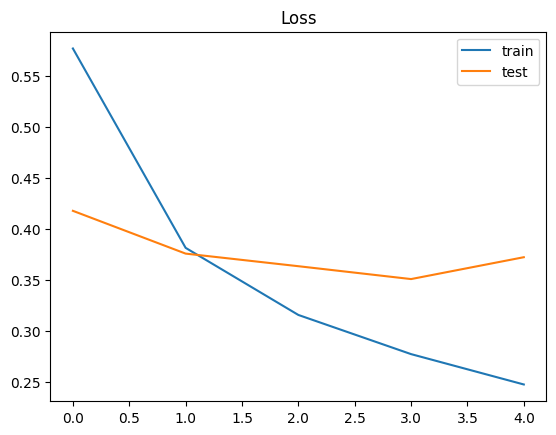

In [36]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()